In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
sys.path.append("/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines")
PATH = "/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import georges
import physics
from magnets import esbtsquad_current_to_gradient

In [2]:
r = 25
energy = georges.physics.range_to_energy(r)
pc = georges.physics.energy_to_momentum(energy)
brho = georges.physics.momentum_to_brho(pc)
context = {
        'PARTICLE': 'PROTON',
        'PC': pc,
        'BETAX'   : physics.get_degrader_spot_size(energy)/physics.get_degrader_divergence(energy),
        'BETAY'   : physics.get_degrader_spot_size(energy)/physics.get_degrader_divergence(energy),
        'ALPHAX': 0.0,
        'ALPHAY': 0.0,
        'DELTAP': 0.0,
        'DPP': 0.2e-2,
        'MOMENTUM_SLITS_OPENING' : 1.015,
        'DIVERGENCE_SLITS_OPENING_X' : 1.015,
        'DIVERGENCE_SLITS_OPENING_Y' : 1.015,
        'N_TRACKING': 5000,
        'EMITX': 1e-6*physics.get_degrader_spot_size(energy)*physics.get_degrader_divergence(energy),
        'EMITY': 1e-6*physics.get_degrader_spot_size(energy)*physics.get_degrader_divergence(energy),
        'IQ1E': esbtsquad_current_to_gradient(61.3648)/brho,
        'IQ2E': -esbtsquad_current_to_gradient(125.0646)/brho,
        'IQ3E': esbtsquad_current_to_gradient(87.29035)/brho,
        'IQ47E': -esbtsquad_current_to_gradient(65.06655)/brho,
        'IQ56E': esbtsquad_current_to_gradient(56.10315)/brho,
        'IQ8E': esbtsquad_current_to_gradient(63.98455)/brho,
        'IQ9E': -esbtsquad_current_to_gradient(62.71815)/brho,
        'IQ10E': esbtsquad_current_to_gradient(21.15985)/brho,
        'IQ1B1': esbtsquad_current_to_gradient(107.67265)/brho,
        'IQ2B1': -esbtsquad_current_to_gradient(109.94395)/brho,
        'IQ3B1': esbtsquad_current_to_gradient(107.67265)/brho,
        'IQ1F1': -esbtsquad_current_to_gradient(41.27555)/brho,
        'IQ2F1': esbtsquad_current_to_gradient(36.8144)/brho,
}

In [10]:
bl = georges.Beamline(['fstr1'], survey=True, path=PATH, prefix='PAT107', elements='elements')
bl.line = bl.line.append(pd.Series({'PHYSICAL': True, 'AT_ENTRY': 1.75, 'AT_CENTER': 1.75, 'AT_EXIT': 1.75, 'TYPE': 'COLLIMATOR', 'CLASS': 'COLLIMATOR', 'APERTYPE': 'RECTANGLE', 'APERTURE': '[0.06, 0.02]'}).rename("DIV")).sort_values(by='AT_CENTER')
bl.line = bl.line.append(pd.Series({'PHYSICAL': True, 'AT_ENTRY': 5.5, 'AT_CENTER': 5.5, 'AT_EXIT': 5.5, 'TYPE': 'COLLIMATOR', 'CLASS': 'COLLIMATOR', 'APERTYPE': 'RECTANGLE', 'APERTURE': '[0.0125, 0.1]'}).rename("MOM")).sort_values(by='AT_CENTER')

bl_survey = georges.madx.survey(line=bl, context=context)
bl_twiss = georges.madx.twiss(line=bl, context=context, ptc=False, debug=False)
b = georges.Beam(energy=200).from_5d_multigaussian_distribution(context['N_TRACKING'],
                                                   XRMS=physics.get_degrader_spot_size(energy)/1000/4,
                                                   PXRMS=physics.get_degrader_divergence(energy)/1000/4,
                                                   YRMS=physics.get_degrader_spot_size(energy)/1000,
                                                   PYRMS=physics.get_degrader_divergence(energy)/1000/2,
                                                   DPPRMS=0.00)
bl_track = georges.madx.track(line=bl.add_markers(), context=context, beam=b, debug=False)

/usr/local/lib/python3.6/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


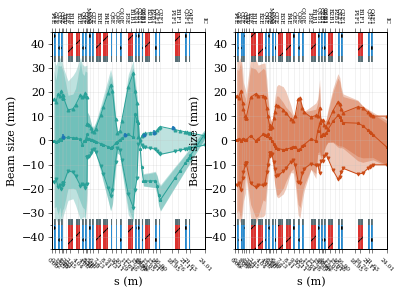

In [14]:
from georges.plotting import *
with plt.style.context('word'):
    fig = plt.figure(1)

    ax1 = fig.add_subplot(121)
    prepare(ax1, bl)
    aperture(ax1, bl)
    #twiss(ax1, bl_twiss, context)
    tracking(ax1, bl_track, plane='X')
    

    x = [1.75,11.5, 14.5, 16, 19]
    y= [1.50,2.273, 2.2431, 3.27796, 5.13184091]
    err = [1, 1, 1, 1, 1]
    ax1.errorbar(x, y, yerr=err, fmt='o')
    
    ax2 = fig.add_subplot(122)
    prepare(ax2, bl)
    aperture(ax2, bl)
    #twiss(ax1, bl_twiss, context)
    tracking(ax2, bl_track, plane='Y')